In [11]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [12]:
df = pd.read_csv('AAPL.csv')
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600
5,1980-12-19,0.126116,0.126674,0.126116,0.126116,0.098578,48630400
6,1980-12-22,0.132254,0.132813,0.132254,0.132254,0.103376,37363200
7,1980-12-23,0.137835,0.138393,0.137835,0.137835,0.107739,46950400
8,1980-12-24,0.145089,0.145647,0.145089,0.145089,0.113409,48003200
9,1980-12-26,0.158482,0.159040,0.158482,0.158482,0.123877,55574400


In [13]:
target_columns = ['Date', 'Close']
df = df[target_columns]
df.head()

,Date,Close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10409 entries, 0 to 10408
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10409 non-null  object 
 1   Close   10409 non-null  float64
dtypes: float64(1), object(1)
memory usage: 162.8+ KB


In [15]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=69, shuffle=False)

In [16]:
dates = data_train['Date'].values
stock = data_train['Close'].values
dates_test = data_test['Date'].values
stock_test = data_test['Close'].values

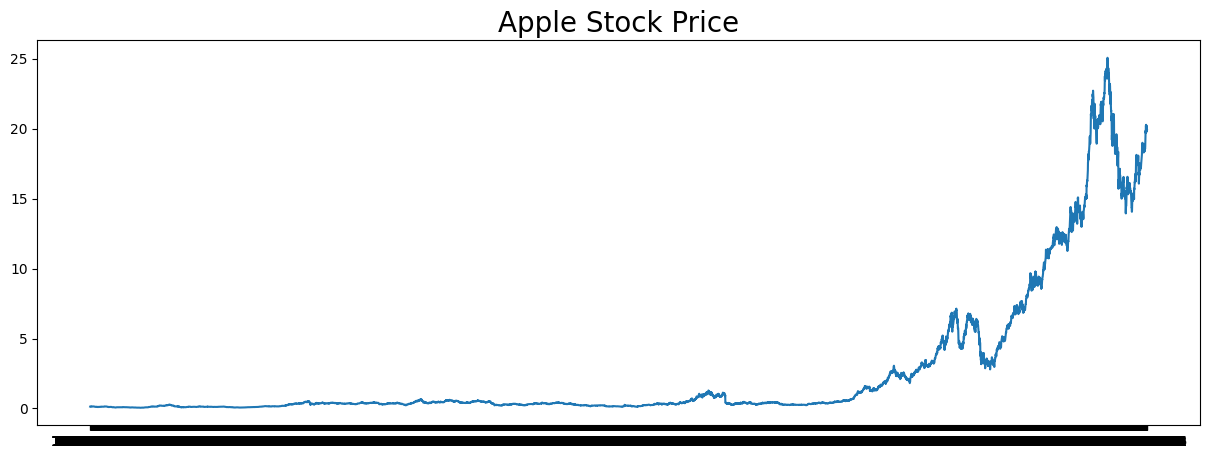

In [17]:
plt.figure(figsize=(15,5))
plt.plot(dates,stock)
plt.title('Apple Stock Price', fontsize=20)
plt.show()

In [18]:
min_max_scaler = MinMaxScaler()
stock = stock.reshape(-1,1)
stock_test = stock_test.reshape(-1,1)
min_max_scaler.fit(stock)

stock = min_max_scaler.transform(stock)
stock_test = min_max_scaler.transform(stock_test)

print(stock)
print(stock_test)

[[0.00316636]
 [0.0028988 ]
 [0.00254201]
 ...
 [0.7979806 ]
 [0.78926107]
 [0.79364222]]
[[0.79006029]
 [0.78403792]
 [0.77503297]
 ...
 [6.74385099]
 [6.79939346]
 [6.9536337 ]]


In [19]:
threshold_mae = (stock.max() - stock.min()) * 10/100
print(threshold_mae) #mae model harus lebih kecil dari ini

0.09999999999999998


In [20]:
class BerhentiBos(tf.keras.callbacks.Callback):
  def __init__(self, sabar_mae=100, sabar_loss=100):
    super(BerhentiBos, self).__init__()
    self.sabar_mae = sabar_mae
    self.sabar_loss = sabar_loss
    self.limit_mae = sabar_mae
    self.limit_loss = sabar_loss

  def on_epoch_end(self, epoch, logs={}):
    if logs.get('mae')<threshold_mae and logs.get('val_mae')<threshold_mae:
      self.sabar_mae -= 1
    else:
      self.sabar_mae += 1

    if logs.get('loss')>threshold_mae or logs.get('val_loss')>threshold_mae:
      self.sabar_loss -= 1
    else:
      self.sabar_loss += 1

    if self.sabar_mae == 0:
      print(f"The model MAE has been below threshold for {self.limit_mae} epochs, Stopping training immediatly!!!")
      self.model.stop_training = True
    elif self.sabar_loss == 0:
      print(f"The model loss has been above threshold for {self.limit_loss} epochs, Stopping training immediatly!!!")
      self.model.stop_training = True

In [21]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [22]:
train_set = windowed_dataset(stock, window_size=50, batch_size=100,shuffle_buffer=1000)
test_set = windowed_dataset(stock_test, window_size=50, batch_size=100, shuffle_buffer=1000)
model = tf.keras.Sequential([
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(32, activation="relu"),
    Dense(12, activation="relu"),
    Dropout(0.5),
    Dense(1)
])

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.Huber(),
    metrics=['mae']
)

In [24]:
berhenti_bos = BerhentiBos(sabar_mae=25)
mymodel = model.fit(
    train_set,
    epochs=100,
    validation_data=test_set,
    callbacks=[berhenti_bos],
    verbose=2
)

Epoch 1/100
83/83 - 17s - loss: 0.0215 - mae: 0.0909 - val_loss: 1.8693 - val_mae: 2.3666 - 17s/epoch - 205ms/step
Epoch 2/100
83/83 - 13s - loss: 0.0163 - mae: 0.1055 - val_loss: 1.7719 - val_mae: 2.2661 - 13s/epoch - 153ms/step
Epoch 3/100
83/83 - 12s - loss: 0.0163 - mae: 0.1170 - val_loss: 1.7369 - val_mae: 2.2294 - 12s/epoch - 142ms/step
Epoch 4/100
83/83 - 12s - loss: 0.0156 - mae: 0.1169 - val_loss: 1.7097 - val_mae: 2.2008 - 12s/epoch - 144ms/step
Epoch 5/100
83/83 - 12s - loss: 0.0147 - mae: 0.1141 - val_loss: 1.6855 - val_mae: 2.1752 - 12s/epoch - 146ms/step
Epoch 6/100
83/83 - 12s - loss: 0.0142 - mae: 0.1127 - val_loss: 1.6616 - val_mae: 2.1499 - 12s/epoch - 143ms/step
Epoch 7/100
83/83 - 12s - loss: 0.0130 - mae: 0.1081 - val_loss: 1.6365 - val_mae: 2.1230 - 12s/epoch - 146ms/step
Epoch 8/100
83/83 - 12s - loss: 0.0125 - mae: 0.1053 - val_loss: 1.6129 - val_mae: 2.0975 - 12s/epoch - 146ms/step
Epoch 9/100
83/83 - 12s - loss: 0.0117 - mae: 0.1015 - val_loss: 1.5919 - val_ma

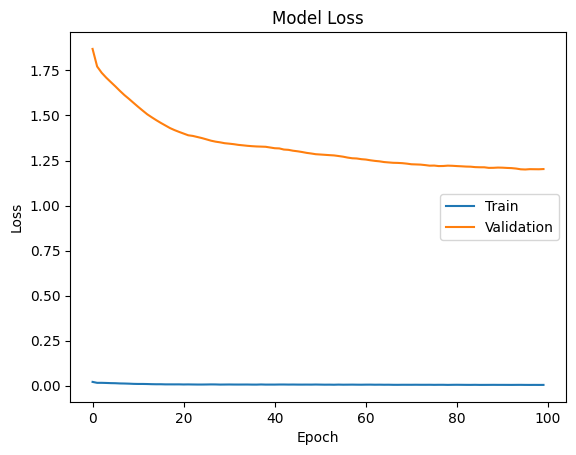

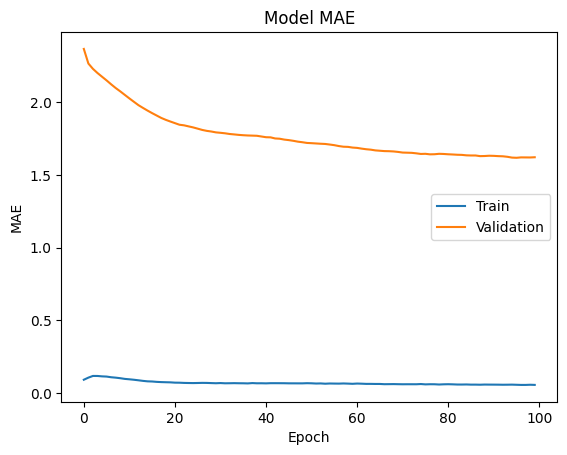

In [25]:
plt.plot(mymodel.history['loss'])
plt.plot(mymodel.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

plt.plot(mymodel.history['mae'])
plt.plot(mymodel.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [26]:
predictions = model.predict(test_set)

21/21 [==============================] - 2s 50ms/step


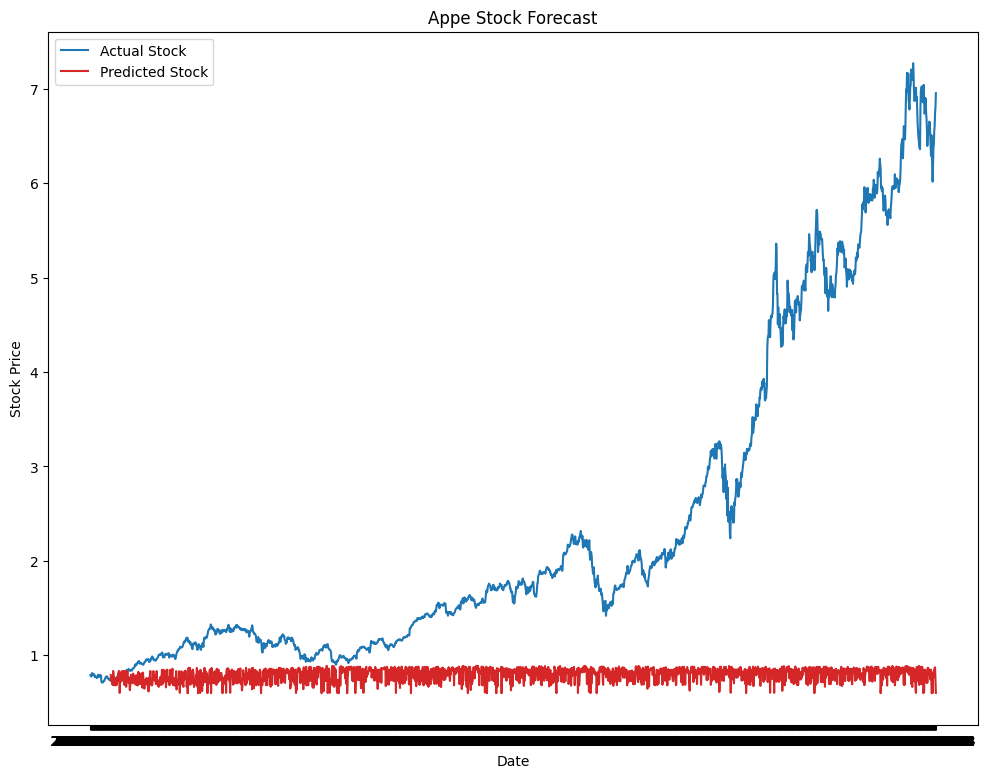

In [28]:
plt.figure(figsize=(12,9))
plt.plot(dates_test, stock_test, label="Actual Stock")
plt.plot(dates_test[50:], predictions, label="Predicted Stock", color="C3")
plt.legend()
plt.title("Appe Stock Forecast")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()